### 获取数据
演示这个模型的常见数据集是手写数字识别MNIST，它长这个样子。
![image.png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/mnist.png)

这里我们用了一个稍微复杂点的数据集，它跟MNIST非常像，但是内容不再是分类数字，而是服饰。gluon可以用过data.vision模块自动下载这个数据。但是因为我用tensorflow，所以在https://github.com/zalandoresearch/fashion-mnist 手动下载了数据。

分别是：

train-images-idx3-ubyte.gz	
train-labels-idx1-ubyte.gz	
t10k-images-idx3-ubyte.gz	
t10k-labels-idx1-ubyte.gz	

然后用tensorflow定义好的接口读取上面的文件

In [1]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels
from tensorflow.python.platform import gfile

train_image_file = '../data/fashion_mnist/train-images-idx3-ubyte.gz'
train_labels_file = '../data/fashion_mnist/train-labels-idx1-ubyte.gz'
test_image_file = '../data/fashion_mnist/t10k-images-idx3-ubyte.gz'
test_labels_file = '../data/fashion_mnist/t10k-labels-idx1-ubyte.gz'

with gfile.Open(train_image_file, 'rb') as f:
    train_images = extract_images(f)

with gfile.Open(train_labels_file, 'rb') as f:
    train_labels = extract_labels(f, one_hot=True, num_classes=10)

with gfile.Open(test_image_file, 'rb') as f:
    test_images = extract_images(f)
    
with gfile.Open(test_labels_file, 'rb') as f:
    test_labels = extract_labels(f, one_hot=True, num_classes=10)

print train_images.shape
print train_labels[0]

print test_images.shape

Extracting ../data/fashion_mnist/train-images-idx3-ubyte.gz
Extracting ../data/fashion_mnist/train-labels-idx1-ubyte.gz
Extracting ../data/fashion_mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/fashion_mnist/t10k-labels-idx1-ubyte.gz
(60000, 28, 28, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(10000, 28, 28, 1)


我们画出前几个样本的内容，和对应的文本标号



In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28, 28)))
        #隐藏x,y坐标
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

def get_text_labels(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

data = train_images[0:9]
label = np.argmax(train_labels,axis=1)[0:9]
show_images(data)
print(get_text_labels(label))

['ankle boot', 't-shirt', 't-shirt', 'dress,', 't-shirt', 'pullover', 'sneaker', 'pullover', 'sandal']


### 数据读取
虽然我们可以像前面那样通过yield来定义获取批量数据函数，原文使用了gluon.data的DataLoader函数，它每次yield一个批量。在tensorflow中同样可以使用定义好的接口，创建Dataset对象。

In [3]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet
train_dataset = DataSet(train_images, train_labels, one_hot=True)

### 初始化模型参数
跟线性模型一样，每个样本会表示成一个向量。我们这里数据是 28 * 28 大小的图片，所以输入向量的长度是 28 * 28 = 784。因为我们要做多类分类，我们需要对每一个类预测这个样本属于此类的概率。因为这个数据集有10个类型，所以输出应该是长为10的向量。这样，我们需要的权重将是一个 784 * 10 的矩阵：

In [4]:
import tensorflow as tf
num_inputs = 784
num_outputs = 10

with tf.name_scope('lr'):
    W = tf.Variable(tf.random_normal([num_inputs, num_outputs], mean=0.0, stddev=1.0, seed=None, dtype=tf.float32), name='weights')
    b = tf.Variable(tf.constant(0.1, shape=[num_outputs]), name='bias')
    #W = tf.Variable(tf.zeros([784, 10]), name='weights')
    #b = tf.Variable(tf.zeros([10]), name='bias')


### 定义模型
在线性回归教程里，我们只需要输出一个标量$yhat$使得尽可能的靠近目标值。但在这里的分类里，我们需要属于每个类别的概率。这些概率需要值为正，而且加起来等于1. 而如果简单的使用 $\boldsymbol{\hat y} = \boldsymbol{W} \boldsymbol{x}$, 我们不能保证这一点。一个通常的做法是通过softmax函数来将任意的输入归一化成合法的概率值。

In [5]:
def np_softmax(X):
    eps = 1e-18
    exp = np.exp(X + eps)
    # 假设exp是矩阵，这里对行进行求和，并要求保留axis 1，
    # 就是返回 (nrows, 1) 形状的矩阵
    partition = np.sum(exp, axis=1, keepdims=True)
    return exp / partition

def tf_softmax(X):
    eps=1e-18
    exp = tf.exp(X)
    # 假设exp是矩阵，这里对行进行求和，并要求保留axis 1，
    # 就是返回 (nrows, 1) 形状的矩阵
    partition = tf.reduce_sum(exp, axis=1, keep_dims=True)
    return exp / partition

可以看到，对于随机输入，我们将每个元素变成了非负数，而且每一行加起来为1。



In [6]:
import numpy as np
X = np.random.normal(size=(2,5))
print X
X_prob = np_softmax(X)
print(X_prob)
#print(X_prob.sum(axis=1))

[[-1.11481442  1.33921703  2.73831238 -1.30705263 -0.52536617]
 [ 2.69731241  1.12879095 -0.40406067  0.59043229  0.59941436]]
[[0.01602474 0.18645044 0.75541013 0.01322218 0.02889251]
 [0.66770325 0.13911798 0.03003823 0.08120394 0.0819366 ]]


现在我们可以定义模型了：



In [7]:
def net(X, weights, bias):
    z = tf.matmul(X, weights) + bias
    return tf_softmax(z), z
    #return z

### 交叉熵损失函数
我们需要定义一个针对预测为概率值的损失函数。其中最常见的是交叉熵损失函数，它将两个概率分布的负交叉熵作为目标值，最小化这个值等价于最大化这两个概率的相似度。

具体来说，我们先将真实标号表示成一个概率分布，例如如果``y=1``，那么其对应的分布就是一个除了第二个元素为1其他全为0的长为10的向量，也就是 `yvec=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`。那么交叉熵就是`yvec[0]*log(yhat[0])+...+yvec[n]*log(yhat[n])`。注意到yvec里面只有一个1，那么前面等价于`log(yhat[y])`。所以我们可以定义这个损失函数了。

In [8]:
import tensorflow as tf
def cross_entropy(yhat, y):
    #yhat和y都是batch_size*num_classes的向量
    eps = 1e-18
    y = tf.cast(y, tf.float32)
    return tf.reduce_mean(-y * tf.log(yhat+eps))

### 计算精度
给定一个概率输出，我们将预测概率最高的那个类作为预测的类，然后通过比较真实标号我们可以计算精度：

In [9]:
def accuracy(output, label):
    #output, label都是batch_size*1的向量
    num_samples = output.get_shape().as_list()[0]
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, 1),tf.argmax(label, 1)), tf.float32))

### 训练
训练代码跟前面的线性回归非常相似：



In [16]:
import sys
import pdb

num_epochs = 20
batch_size = 64
image_width = image_height = 28
num_train_samples = 60000
learning_rate = 1e0

input_placeholder = tf.placeholder(tf.float32, [None, num_inputs])
gt_placeholder = tf.placeholder(tf.int64, [None, num_outputs])
softmax_predict, logit = net(input_placeholder, W, b)
loss = cross_entropy(softmax_predict, gt_placeholder)
acc = accuracy(softmax_predict, gt_placeholder)
var_list = tf.trainable_variables()
for var in var_list:
    print var.op.name
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
train_loss = 0.
train_acc = 0.
test_images_reshape = np.reshape(np.squeeze(test_images), (test_images.shape[0], image_height*image_width))


for epoch in range(num_epochs):
    for batch in range(60000/batch_size):
        data, label = train_dataset.next_batch(batch_size)
        data = np.reshape(data, (batch_size, image_height*image_width))
        feed_dict = {input_placeholder: data, gt_placeholder: label}
        loss_, acc_, _ = sess.run([loss, acc, train_op], feed_dict=feed_dict)
        if batch % 100 == 0:
            print("Epoch %d, Batch %d, Loss: %f, Train acc %f " % (epoch, batch, loss_, acc_))
    test_loss_, test_acc_ = sess.run([loss, acc], feed_dict={input_placeholder: test_images_reshape / 255.0, gt_placeholder: test_labels})
    print ("Epoch %d, Test Loss: %f, Test acc %f " % (epoch, test_loss_, test_acc_))
    #test_acc = evaluate_accuracy(test_data, net)
    

lr/weights
lr/bias
Epoch 0, Batch 0, Loss: 1.372785, Train acc 0.171875 
Epoch 0, Batch 100, Loss: 0.222798, Train acc 0.546875 
Epoch 0, Batch 200, Loss: 0.279642, Train acc 0.468750 
Epoch 0, Batch 300, Loss: 0.216706, Train acc 0.531250 
Epoch 0, Batch 400, Loss: 0.139442, Train acc 0.750000 
Epoch 0, Batch 500, Loss: 0.103321, Train acc 0.656250 
Epoch 0, Batch 600, Loss: 0.107369, Train acc 0.750000 
Epoch 0, Batch 700, Loss: 0.093431, Train acc 0.750000 
Epoch 0, Batch 800, Loss: 0.136332, Train acc 0.765625 
Epoch 0, Batch 900, Loss: 0.091566, Train acc 0.796875 
Epoch 0, Test Loss: 0.138095, Test acc 0.697000 
Epoch 1, Batch 0, Loss: 0.120773, Train acc 0.687500 
Epoch 1, Batch 100, Loss: 0.096433, Train acc 0.718750 
Epoch 1, Batch 200, Loss: 0.096708, Train acc 0.734375 
Epoch 1, Batch 300, Loss: 0.107570, Train acc 0.687500 
Epoch 1, Batch 400, Loss: 0.075544, Train acc 0.765625 
Epoch 1, Batch 500, Loss: 0.146705, Train acc 0.718750 
Epoch 1, Batch 600, Loss: 0.117502, Trai

Epoch 13, Batch 500, Loss: 0.051088, Train acc 0.859375 
Epoch 13, Batch 600, Loss: 0.025355, Train acc 0.890625 
Epoch 13, Batch 700, Loss: 0.077513, Train acc 0.796875 
Epoch 13, Batch 800, Loss: 0.047322, Train acc 0.828125 
Epoch 13, Batch 900, Loss: 0.071855, Train acc 0.765625 
Epoch 13, Test Loss: 0.068268, Test acc 0.806400 
Epoch 14, Batch 0, Loss: 0.026761, Train acc 0.921875 
Epoch 14, Batch 100, Loss: 0.067886, Train acc 0.765625 
Epoch 14, Batch 200, Loss: 0.060385, Train acc 0.796875 
Epoch 14, Batch 300, Loss: 0.061576, Train acc 0.812500 
Epoch 14, Batch 400, Loss: 0.061684, Train acc 0.859375 
Epoch 14, Batch 500, Loss: 0.058525, Train acc 0.828125 
Epoch 14, Batch 600, Loss: 0.056437, Train acc 0.828125 
Epoch 14, Batch 700, Loss: 0.049873, Train acc 0.859375 
Epoch 14, Batch 800, Loss: 0.045839, Train acc 0.812500 
Epoch 14, Batch 900, Loss: 0.045442, Train acc 0.828125 
Epoch 14, Test Loss: 0.065279, Test acc 0.811800 
Epoch 15, Batch 0, Loss: 0.058781, Train acc 0.

### 预测
训练完成后，现在我们可以演示对输入图片的标号的预测

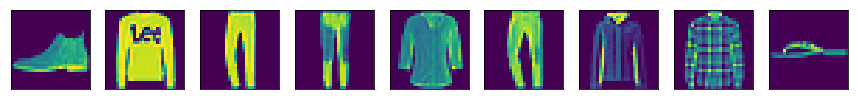

true labels
['ankle boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal']
predicted labels
['ankle boot', 'pullover', 'trouser', 'trouser', 't-shirt', 'trouser', 'coat', 'coat', 'sandal']


In [17]:
data, label = test_images[0:9], test_labels[0:9]
show_images(data)
print('true labels')
print(get_text_labels(np.argmax(label,axis=1)))

predicted_softmax = sess.run([softmax_predict], feed_dict={input_placeholder:np.reshape(data/255.0,(9, image_height*image_width))})

predicted_labels = np.argmax(predicted_softmax[0], axis=1)
print('predicted labels')
print(get_text_labels(predicted_labels))